In [1]:
import os
import flwr as fl
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from opacus import PrivacyEngine
from collections import OrderedDict

from flwr.common import NDArrays, Scalar
from typing import Dict, Optional, Tuple
from typing import List

import pydicom
import rarfile
import zipfile
import pydicom
from PIL import Image
import math, json, os, sys

from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification.pytorch import PyTorchClassifier

2024-06-25 20:52:09.212717: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 20:52:10.340649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

zip_path = 'rsna-pneumonia-detection-challenge.zip'
extract_path = 'rsna-pneumonia-detection-challenge'
#with zipfile.ZipFile(zip_path, 'r') as zf:
#    zf.extractall(extract_path)
train_images_path = os.path.join(extract_path, 'stage_2_train_images')
labels_csv_path = os.path.join(extract_path, 'stage_2_train_labels.csv')
labels_df = pd.read_csv(labels_csv_path)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def extract_features(img):  
    pixel_array = np.array(img)
    return pixel_array
def conv_dcm_img(dicom_path):
    dicom = pydicom.dcmread(dicom_path)
    pixel_array = dicom.pixel_array
    image = Image.fromarray(pixel_array)
    return image
feature_vectors = []
labels = []
for index, row in labels_df.iterrows():
    dicom_id = row['patientId']
    label = row['Target']
    dicom_path = os.path.join(train_images_path, f"{dicom_id}.dcm")    
    if os.path.exists(dicom_path): 
        image=transform(conv_dcm_img(dicom_path))
        feature_vector = extract_features(image)
        feature_vectors.append(feature_vector)
        labels.append(label)
        if index%100==0:
            print(index)
            #if index>4000:
            #    break
X = np.array(feature_vectors)
y = np.array(labels)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#print(X_scaled.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=150)
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing labels shape: {y_test.shape}')




0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [3]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)   

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1
train_losses = []
val_losses = []

privacy_engine = PrivacyEngine()
# Set privacy parameters
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=0.1,
    max_grad_norm=1.0,
  )


/home/dgxuser49/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [5]:
checkpoint_dir = 'DP-CNN_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
f2 = open("DP-CNN-4_1.csv", "a")
f2.write(f"Epoch,Loss,Accuracy,Val_Loss,Val_Accuracy\n")


42

In [6]:
def train(model, train_loader, epochs=35):
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        model = model.to(device)
        model.train()
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            print(f"Loss:{loss}")
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += target.size(0)
            correct += (torch.max(outputs.data, 1)[1] == target).sum().item()
        epoch_loss /= len(train_loader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss:.8f}, accuracy {epoch_acc}")
        f = open("train_xray_35_1.txt", "a")
        f.write(f"Epoch: {epoch+1} Loss: {epoch_loss:.8f}, Accuracy: {epoch_acc:.8f}\n")
        f.close()
        test_correct, test_total, test_loss = 0, 0, 0

        with torch.no_grad():
            for test_data, test_target in test_loader:
                test_data = test_data.to(device)
                test_target = test_target.to(device)
                test_outputs = model(test_data)
                test_loss += criterion(test_outputs, test_target).item()
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_total += test_target.size(0)
                test_correct += (test_predicted == test_target).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = test_correct / test_total
        print(f'Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')
        f1 = open("test_xray_35_1.txt", "a")
        f1.write(f"Loss: {test_loss:.8f}, Accuracy: {test_accuracy:.8f}\n")
        f1.close()
        f2.write(f"{epoch+1},{epoch_loss:.8f},{epoch_acc:.8f},{test_loss:.4f},{test_accuracy:.8f}\n")
    f2.close()
    return model
   


In [7]:
trained_model = train(model, train_loader, epochs=35)

checkpoint_path = os.path.join(checkpoint_dir, f'CNN_DP_epoch_35_1.pth')
torch.save(trained_model, checkpoint_path)
print(f"Model checkpoint saved at {checkpoint_path}")

/home/dgxuser49/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Loss:0.7447509765625
Loss:0.7277767658233643
Loss:0.7097784280776978
Loss:0.6818302869796753
Loss:0.6863495707511902
Loss:0.6801598072052002
Loss:0.5801666975021362
Loss:0.537520170211792
Loss:0.7686923146247864
Loss:0.6483293771743774
Loss:0.9833004474639893
Loss:1.7329050302505493
Loss:2.266166925430298
Loss:2.0597939491271973
Loss:2.3976361751556396
Loss:2.8314805030822754
Loss:2.911057710647583
Loss:2.503418207168579
Loss:2.2039949893951416
Loss:1.3956915140151978
Loss:1.6231883764266968
Loss:1.315238118171692
Loss:1.747418999671936
Loss:1.4038935899734497
Loss:1.6221469640731812
Loss:1.1832507848739624
Loss:0.6536698937416077
Loss:1.1223182678222656
Loss:0.949434220790863
Loss:1.3408576250076294
Loss:1.4880650043487549
Loss:1.1533139944076538
Loss:1.6286141872406006
Loss:1.1798033714294434
Loss:1.8943121433258057
Loss:1.3081133365631104
Loss:1.5953565835952759
Loss:1.6865241527557373
Loss:1.99261474609375
Loss:0.9599886536598206
Loss:0.7664505839347839
Loss:1.224252700805664
Loss:

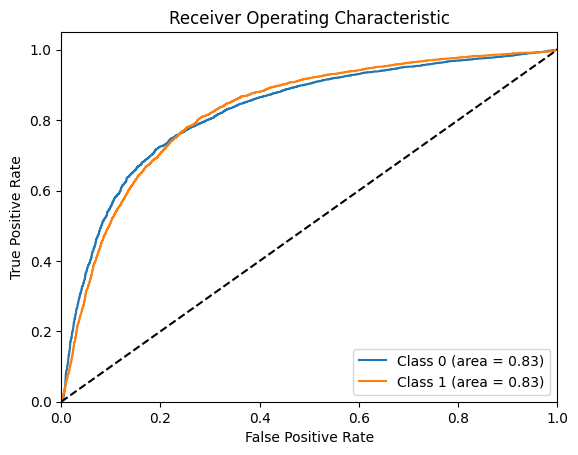

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     10371
           1       0.65      0.65      0.65      4743

    accuracy                           0.78     15114
   macro avg       0.74      0.74      0.74     15114
weighted avg       0.78      0.78      0.78     15114



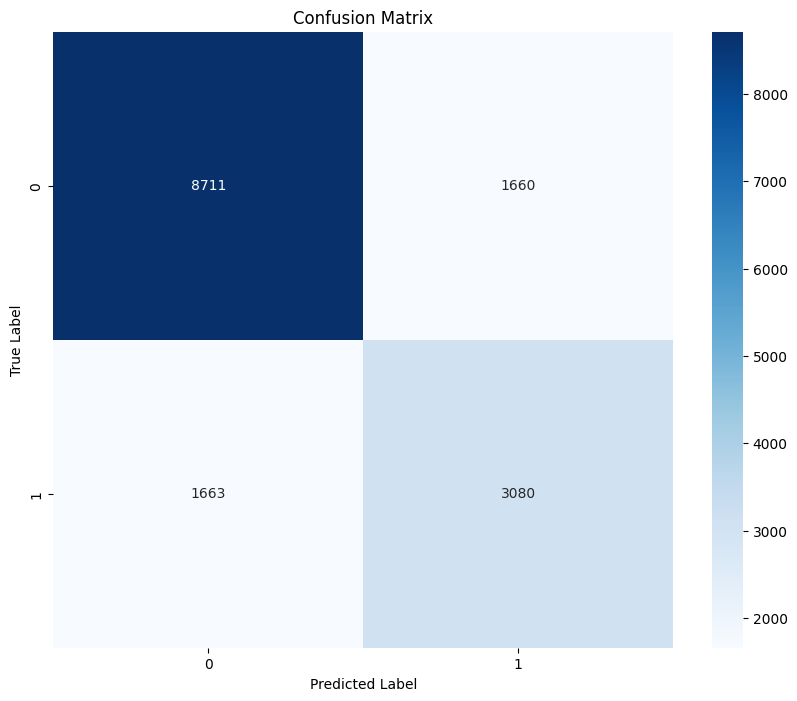

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

if __name__ == "__main__":
    checkpoint_path = os.path.join(checkpoint_dir, f'CNN_DP_epoch_35_1.pth')
    CNN_model =torch.load(checkpoint_path)

    CNN_model = CNN_model.to(device)
    CNN_model.eval()
    
    # Initialize lists to store true labels and predictions
    true_labels = []
    pred_probs = []
    
    # Make predictions
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = CNN_model(images)
            probabilities = torch.softmax(outputs, dim=1)
            pred_probs.extend(probabilities.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)
    pred_labels = np.argmax(pred_probs, axis=1)
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    num_classes=2
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    class_names=['0','1']
    print(classification_report(true_labels, pred_labels, target_names=class_names))
    
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

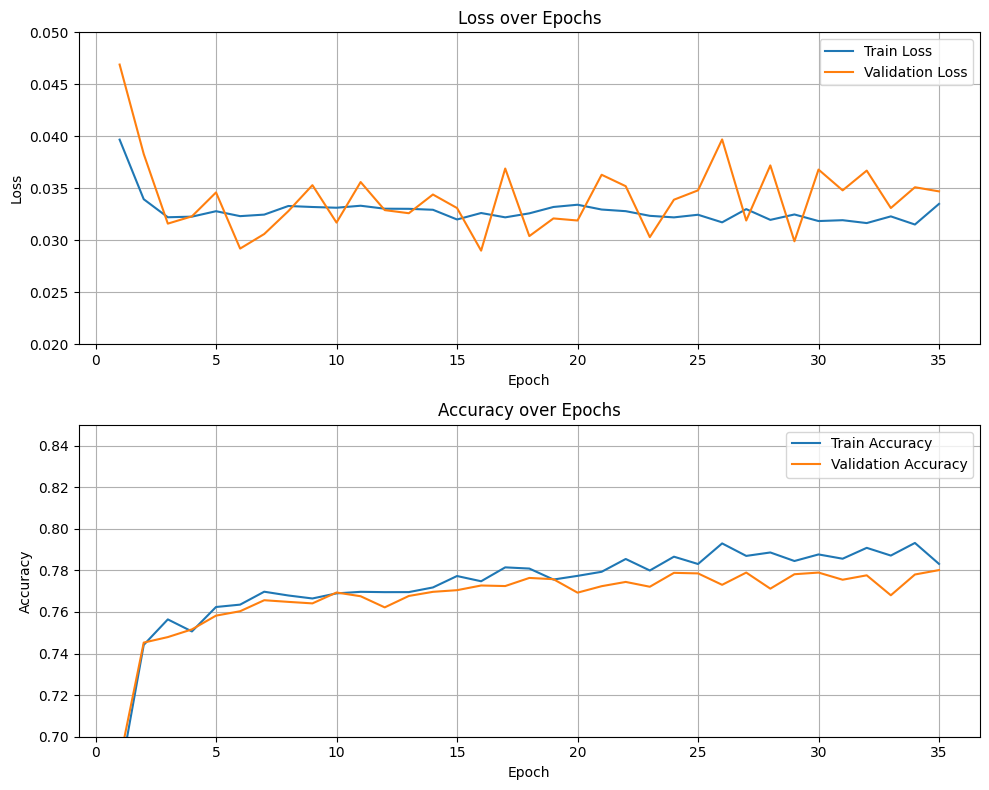

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
file_path = 'DP-CNN-4_1.csv'  # Replace with the actual path to your CSV file
data = pd.read_csv(file_path)

# Extract relevant columns
epochs = data['Epoch']
train_loss = data['Loss']
train_accuracy = data['Accuracy']
val_loss = data['Val_Loss']
val_accuracy = data['Val_Accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss values
ax1.plot(epochs, train_loss, label='Train Loss')
ax1.plot(epochs, val_loss, label='Validation Loss')
ax1.set_ylim([0.02, 0.05])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Epochs')
ax1.legend()
ax1.grid(True)

# Plot accuracy values
ax2.plot(epochs, train_accuracy, label='Train Accuracy')
ax2.plot(epochs, val_accuracy, label='Validation Accuracy')
ax2.set_ylim([0.7, 0.85])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.legend()
ax2.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
